In [1]:
# study of the dataset
# looking for an interesting pre-processing before using CNN
# dataset source: https://data.mendeley.com/datasets/rscbjbr9sj/2
# the dataset contains two categories: Normal and Pneumonia
# in the case of Pneumania, the origin can be Virus or Bacteria
# in this study, we try to improve the quality of each image and to
# center the image around the rib cage

In [2]:
import glob
import numpy as np
from scipy import ndimage
from skimage import feature
from PIL import Image
import cv2 
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

In [3]:
# defining path of the dataset
source_path = "/content/gdrive/MyDrive/ML-datasets/Chest_X_Ray/chest_xray/"
source_train = source_path + "train/"
source_test = source_path + "test/"
raw_categories = ["PNEUMONIA", "NORMAL"]

In [4]:
# paths of all images in train, category Pneumonia
images = glob.glob(source_train + raw_categories[0] + "/*", recursive = True)

In [5]:
# choosing images
nb_samples = 5
id_images = np.random.choice(len(images), nb_samples, replace=False)
imgs = [np.array(Image.open(images[id])) for id in id_images]
for img in imgs:
    print("image shape: {}".format(img.shape))

image shape: (1404, 1582)
image shape: (576, 1064)
image shape: (816, 1152)
image shape: (656, 984)
image shape: (864, 1304)


In [6]:
id_images

array([3535, 2233,  127, 2845,  466])

In [ ]:
# we define a function to plot several images in a grid 

In [7]:
def plot_grid(h, w, list_imgs, row_titles=[]):
    nb = len(list_imgs)
    plt.rcParams['figure.figsize'] = [15, 15]
    fig, axs = plt.subplots(h, w)
    for i in range(nb):
        if h == 1:
            axi = axs[i%w]
        elif w == 1:
            axi = axs[i]
        else:
            axi = axs[i//w, i%w]
        axi.imshow(list_imgs[i], cmap='gray')
        #axi.set_axis_off()
        axi.set_yticklabels([])
        axi.set_xticklabels([])
        axi.set_xticks([])
        axi.set_yticks([])
    if row_titles != []:
        if h == 1:
            axs[0].set_ylabel(row_titles[0], rotation=90, size='large')
        else:
            for i in range(min(h, len(row_titles))):
                axs[i, 0].set_ylabel(row_titles[i], rotation=90, size='large')
    plt.show()

In [ ]:
# we plot some samples 

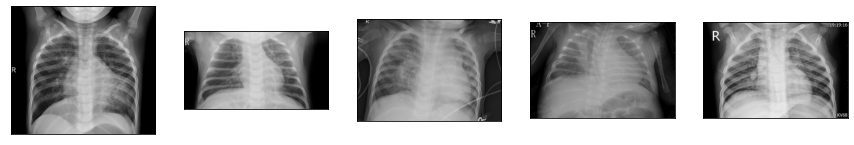

In [8]:
plot_grid(1, 5, imgs) 

In [9]:
# image pre-processing
# we define a function to apply an operation with different parameters
# to many images and we plot them in a grid
# it allows observing the effects

In [69]:
def plot_grid_func(imgs, start, end, step, func, param_name="param"):
    imgs_trt = []
    row_titles = []
    params = np.arange(start, end, step=step)
    for s in params:
        row_titles += [param_name + ": {}".format(s)]
        for img in imgs:
            try:
                imgs_trt += [func(img, s)]
            except:
                print("plot_grid_func failed!")
                imgs_trt += [img]
    plot_grid(params.shape[0], len(imgs), imgs_trt, row_titles)

In [ ]:
# we test some operations; we seek to detect the rib cage 

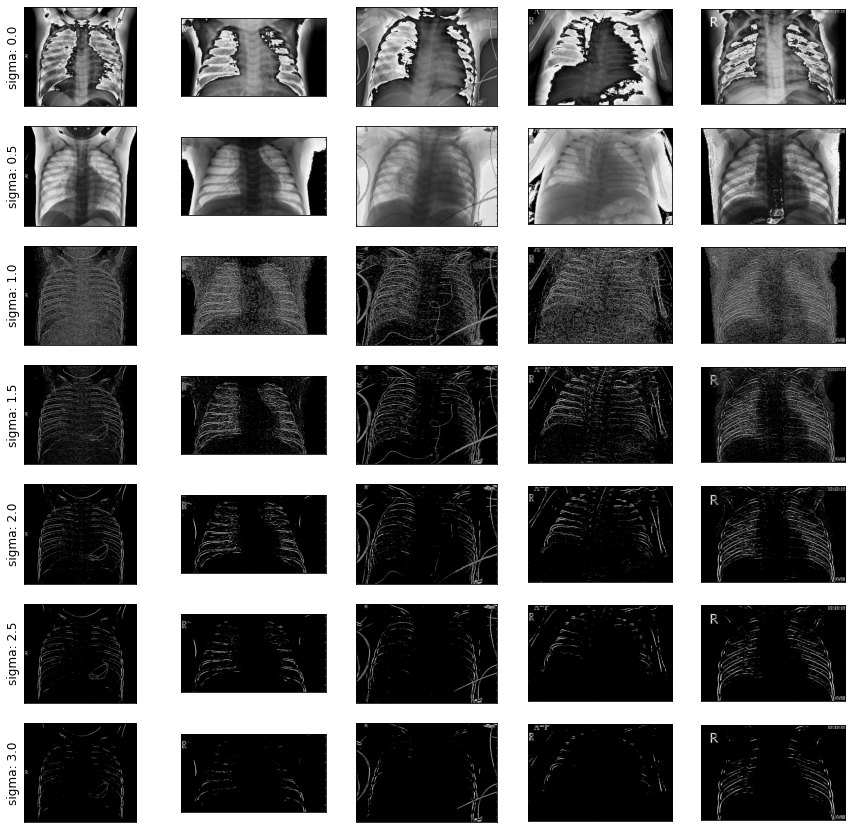

In [11]:
func = lambda x, s: ndimage.gaussian_laplace(x, sigma=s)
plot_grid_func(imgs, 0, 3.5, 0.5, func, param_name="sigma")

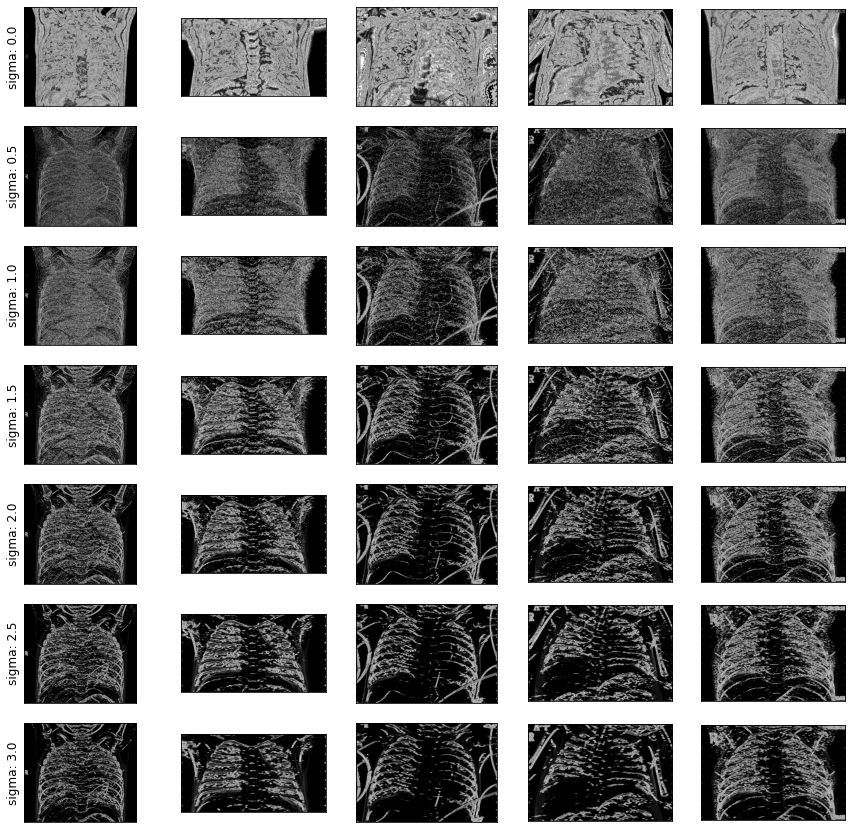

In [12]:
func = lambda x, s: ndimage.gaussian_gradient_magnitude(x, sigma=s)
plot_grid_func(imgs, 0, 3.5, 0.5, func, param_name="sigma")

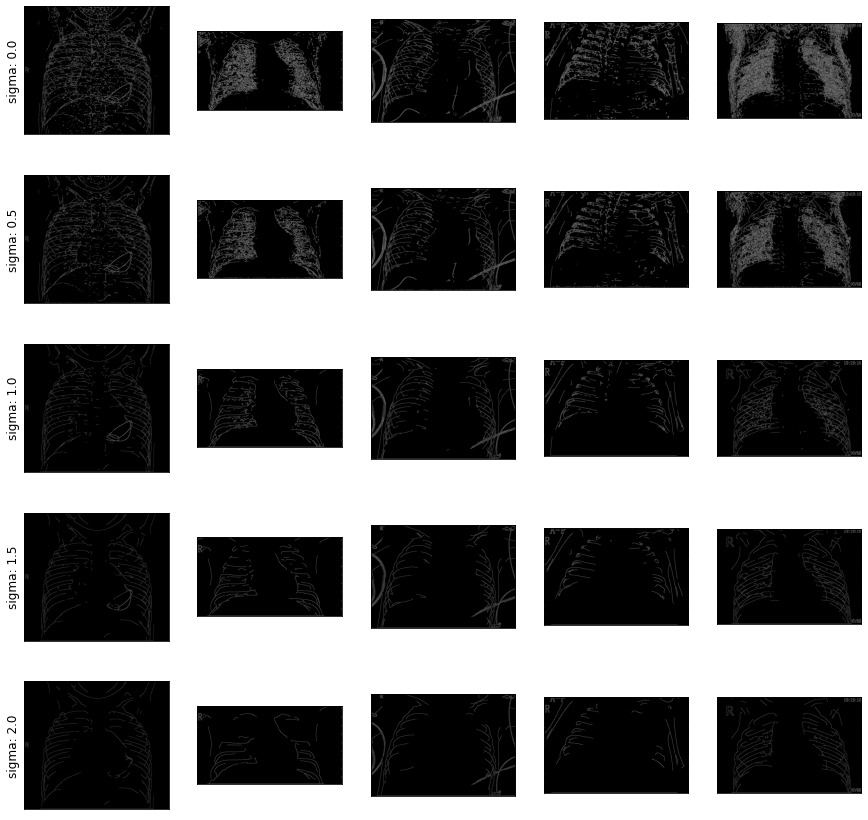

In [13]:
# Canny filter
func = lambda x, s: feature.canny(x, sigma=s)
plot_grid_func(imgs, 0, 2.5, 0.5, func, param_name="sigma")

In [ ]:
# the gaussian filter and the canny filter can be used; the main idea is to identify the pixels 
# of the rib cage (by filtering in values...)

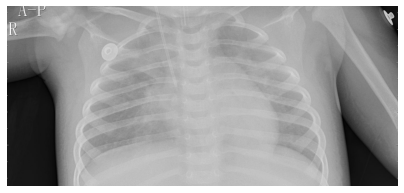

In [14]:
# trying to detect rib cage...
def plot_image(img):
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
id = 2684  # selected because it looks interesting
img = np.array(Image.open(images[id]))
plot_image(img)

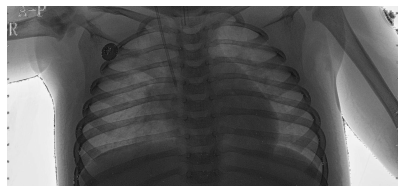

In [15]:
# applying filter
img_filter = ndimage.gaussian_laplace(img, sigma=0.5)
plot_image(img_filter)

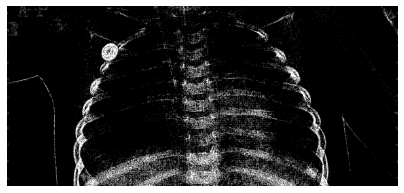

In [16]:
# Note: in this image, the application of the filter improve the quality of the picture
# we apply a binary filter to identify the rib cage
img_threshold = np.where(img_filter > 40, 0, 1)
plot_image(img_threshold)

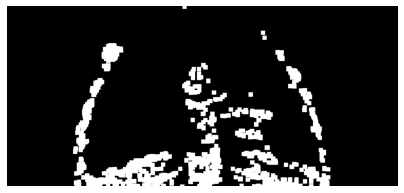

In [17]:
# erosion and dilatation allow selecting the external part of the rib cage
img_threshold = np.where(img_filter > 50, 0, 1)
kernel = np.ones((4,4), np.uint8) 
img_cv = img_threshold.astype('uint8')
img_e_d = cv2.erode(img_cv, kernel, iterations=2)
img_e_d = cv2.dilate(img_e_d, kernel, iterations=5) 
plot_image(img_e_d)

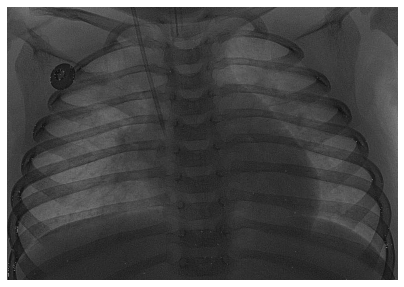

In [18]:
# identification of the rib cage in the picture: we can crop it
# the image
cnt = cv2.findNonZero(img_e_d)
x,y,w,h = cv2.boundingRect(cnt)
img_s = img_filter[y:(y+h), x:(x+w)]
img_reference = img_s
plot_image(img_s)

In [ ]:
# we create a pipline to reproduce the process and we try it on several images

In [19]:
# creating the pipeline to crop the image around the rib cage 
def pipeline_0(img, h=250, w=250):
    #resizing the image
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
    img_filter = img.copy()
    
    try:
        # changing contrast and brightness
        alpha = 2.0  # contrast
        beta = 50.0  # brightness
        img_filter = cv2.convertScaleAbs(img_filter, alpha=alpha, beta=beta)

        # separation : rib cage is darker than the rest
        img_filter = np.where(img_filter > 240, 1, 0)
        
        # cleaning the image
        k = 4
        kernel = np.ones((k, k), np.uint8) 
        img_filter = img_filter.astype('uint8')
        img_filter= cv2.erode(img_filter, kernel, iterations=5)

        # detecting the final area
        cnt = cv2.findNonZero(img_filter)
        x,y,ws,hs = cv2.boundingRect(cnt)
        img = img[y:(y+hs), x:(x+ws)]

        # improving contrast
        alpha = 2.0  # contrast
        beta = -150.0  # brightness
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
    except:
        print("Fail!")
        pass
    return img

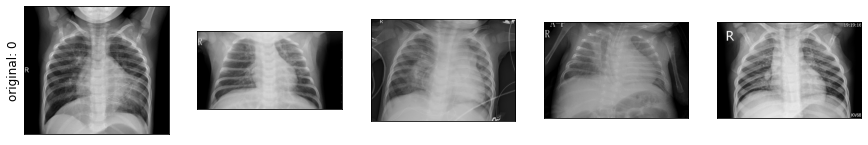

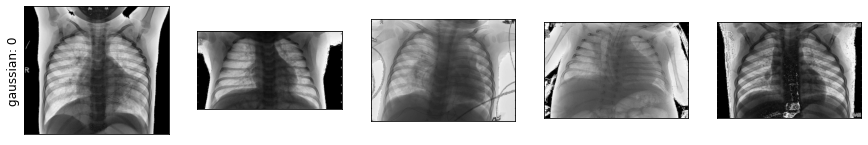

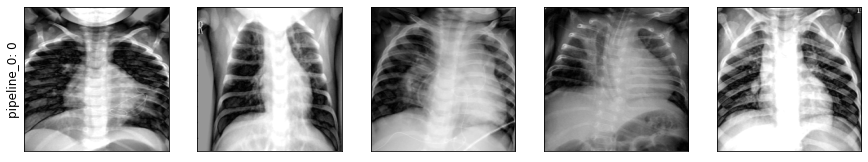

In [20]:
# testing the pipeline_0
plot_grid_func(imgs, 0, 1, 1, lambda x, s: x, param_name="original")
func = lambda x, s: ndimage.gaussian_laplace(x, sigma=0.5)
plot_grid_func(imgs, 0, 1, 1, func, param_name="gaussian")
func = lambda x, s: pipeline_0(x)
plot_grid_func(imgs, 0, 1, 1, func, param_name="pipeline_0")

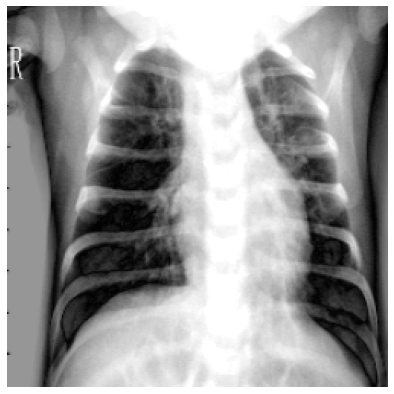

In [21]:
plot_image(pipeline_0(imgs[1]))

Fail!
Fail!
Fail!
Fail!
Fail!
Fail!
Fail!
Fail!
Fail!
Fail!


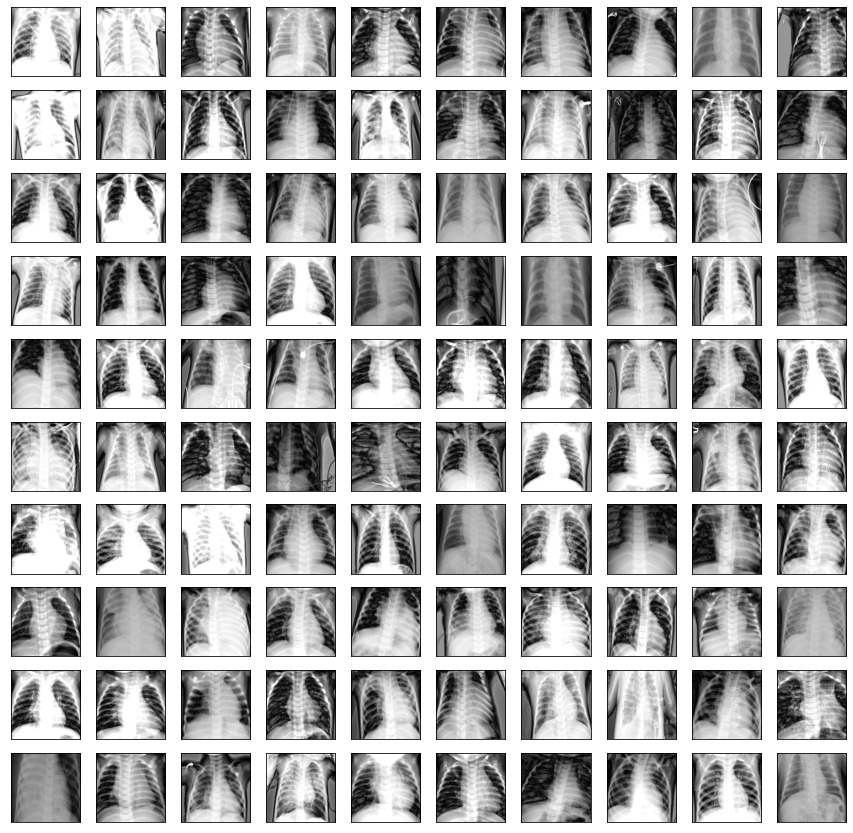

In [22]:
# testing with many samples
nb2_samples = 100
id2_images = np.random.choice(len(images), nb2_samples, replace=False)
imgs2 = [pipeline_0(np.array(Image.open(images[id]))) for id in id2_images]
plot_grid(10, 10, imgs2, row_titles=[])

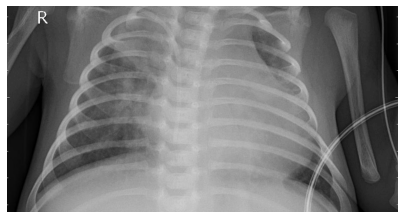

In [23]:
plot_image(np.array(Image.open(images[id2_images[5]]))) 

In [ ]:
# Conclusion about the first pipeline: the results are mitigated, some images are cropped correctly
# and the quality is better. However, there are some fails and some images are not cropped 
# around the rib cage. The rib cage identification process is not valuable for all images
# we try to modify the pipeline: normalize the images (brightness and contrast) and then detection
# of the rib cage

In [24]:
# test pipeline_1 : normalization of contrast and brightness

In [133]:
# creating the pipeline to crop the image around the rib cage 
def pipeline_1(img, h=250, w=250):
    #resizing the image
    # img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_filter = img
    img_filter = cv2.equalizeHist(img_filter) 
    
    alpha = 2.0  # contrast
    beta = 0.0  # brightness
    img_filter = cv2.convertScaleAbs(img_filter, alpha=alpha, beta=beta)
    img_filter = np.where(img_filter>200, 1, 0)
    
    # cleaning the image
    k = 5
    kernel = np.ones((k, k), np.uint8) 
    img_filter = img_filter.astype('uint8')
    img_filter= cv2.erode(img_filter, kernel, iterations=6)

    # detecting the final area
    cnt = cv2.findNonZero(img_filter)
    x,y,ws,hs = cv2.boundingRect(cnt)
    img = img[y:(y+hs), x:(x+ws)]
    
    # improving
    img = cv2.equalizeHist(img)
    alpha = 1.0  # contrast
    beta = 0.0  # brightness
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    
    # reshape
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
    return img

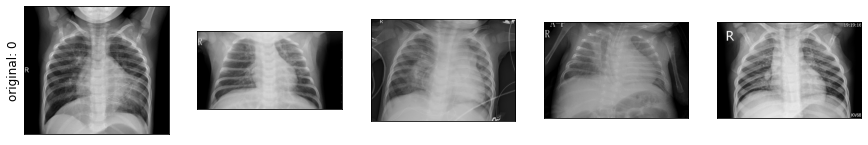

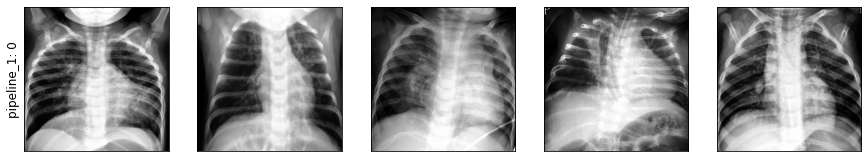

In [134]:
plot_grid_func(imgs, 0, 1, 1, lambda x, s: x, param_name="original")
func = lambda x, s: pipeline_1(x)
plot_grid_func(imgs, 0, 1, 1, func, param_name="pipeline_1")

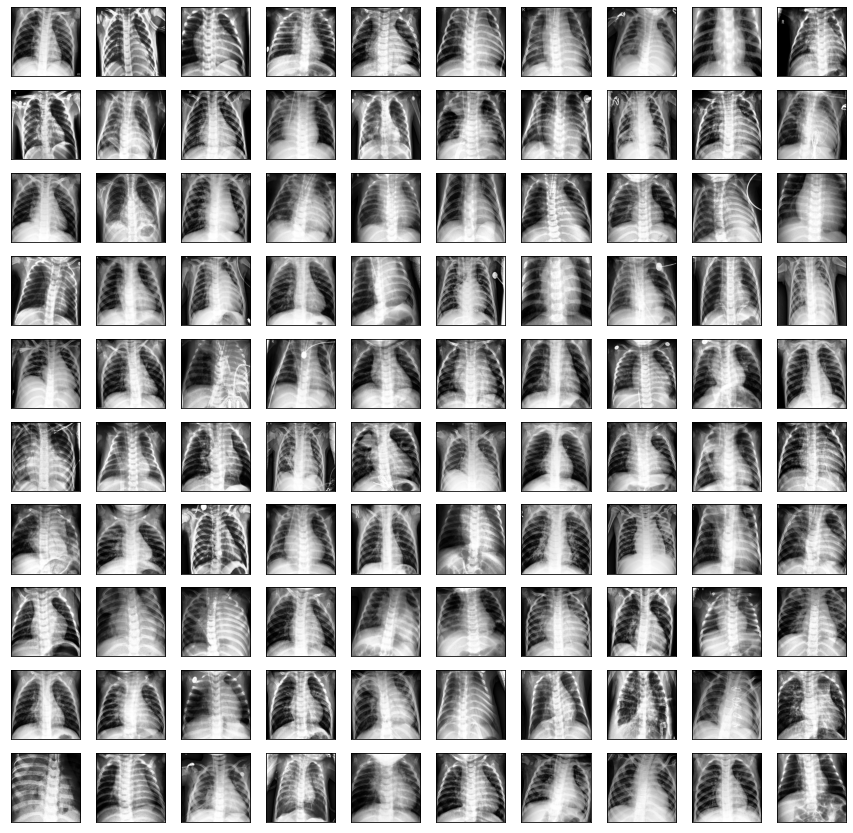

In [136]:
# testing
imgs2 = []
imgs2_fail = []
for id in id2_images:
    im = np.array(Image.open(images[id]))
    try:
        imgs2 += [pipeline_1(im)]
    except:
        imgs2_fail += [im]
plot_grid(10, 10, imgs2, row_titles=[])
# plot_grid(1, 10, imgs2_fail, row_titles=['fail']*1)

In [ ]:
# Conclusion of the second pipeline: the results are better than the first one, the rib cage are
# mostly correctly cropped in many cases and the images are normalized: the brightness and 